In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(device.type)

# ---

torch.manual_seed(42)
np.random.seed(42)

cuda


In [3]:
t_steps = 200
num_demos = 100
num_val = 20
dx, dy = 1, 1
x = torch.linspace(0, 1, t_steps).repeat(int(num_demos/2), 1)

noise = torch.clamp(torch.randn(x.shape)*1e-4**0.5, min=0)
y0 = torch.unsqueeze(torch.sin(x*torch.pi) + noise, 2)

y1 = 1-y0

x = torch.unsqueeze(x.repeat(2,1), 2)
y = torch.cat((y0, y1), 0)
print("X:", x.shape, "Y:", y.shape)

path = "."

#######################################

vx = torch.linspace(0, 1, t_steps).repeat(int(num_val/2), 1)
vnoise = torch.clamp(torch.randn(vx.shape)*1e-4**0.5, min=0)
vy0 = torch.unsqueeze(torch.sin(vx*torch.pi) + vnoise, 2)
vy1 = 1-vy0

vx = torch.unsqueeze(vx.repeat(2,1), 2)
vy = torch.cat((vy0, vy1), 0)

X: torch.Size([100, 200, 1]) Y: torch.Size([100, 200, 1])


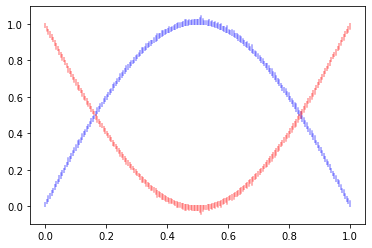

In [4]:
plt.plot(x[:50, :, 0], y[:50, :, 0], 'b', alpha=0.3)
plt.plot(x[51:, :, 0], y[51:, :, 0], 'r', alpha=0.3)
plt.show()

In [5]:
n_max = 6

def sample_training_demonstration():    
    rand_traj_ind = np.random.randint(0, num_demos)
    n = np.random.randint(1, n_max+1)

    rand_traj = y[rand_traj_ind, :, :]

    observation_indices = np.random.choice(np.arange(t_steps), n+1, replace=False) # n+1: +1 is for sampling the target
    
    observations = torch.cat((rand_traj[observation_indices[:-1], :], 
                              x[rand_traj_ind, observation_indices[:-1], :]), 1)
    targetX = torch.unsqueeze(torch.Tensor(x[rand_traj_ind, observation_indices[-1], :]), 0)
    targetY = torch.unsqueeze(torch.Tensor(rand_traj[observation_indices[-1], :]), 0)
    
    type_id = 0 if rand_traj_ind<num_demos/2 else 1
    
    if device.type == 'cuda':
        return observations.float().cuda(), type_id, targetX.float().cuda(), targetY.float().cuda()
    else:
        return observations.float(), type_id, targetX.float(), targetY.float()


def get_validation_demonstration(ind):
    type_id = 0 if ind<num_val/2 else 1
    x = vx[ind, :, :]
    y = vy[ind, :, :]
    
    if device.type == 'cuda':
        return x.float().cuda(), y.float().cuda(), type_id
    else:
        return x, y, type_id

In [6]:
class BCNP(nn.Module):
    def __init__(self, in_shape):
        super(BCNP, self).__init__()
        
        dx, dy = in_shape[0], in_shape[1]
        
        dz = 128
        dzt = dz+dx
        
        self.encoder = nn.Sequential(
            nn.Linear(dx+dy, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, dz)
        )
        
        self.f0 = nn.Sequential(
            nn.Linear(dzt, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, dy*2)
        )

        self.f1 = nn.Sequential(
            nn.Linear(dzt, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, dy*2)
        )
        

    def forward(self, observations, type_id, target):
        z_out = self.encoder(observations)
        z = torch.mean(z_out, dim=0)

        zs = z.repeat(target.shape[0], 1).to(device)  # repeating the same z for each target
        z_target = torch.cat((zs, target), 1)
        
        if type_id == 0:
            return self.f0(z_target)
        else:
            return self.f1(z_target)


def log_prob_loss(ty, ty_pred):
    m, s = ty_pred.chunk(2, dim = -1)
    s = F.softplus(s)
    dist = D.Independent(D.Normal(loc=m, scale=s), 1)
    return -torch.mean(dist.log_prob(ty))


def validate():
    verr=torch.zeros(num_val)
    with torch.no_grad():
        for i in range(num_val):
            val_x, val_y, type_id = get_validation_demonstration(i)

            cond_step = 0
            observation = torch.Tensor([val_y[cond_step, :], val_x[cond_step, :]]).view(1, dx+dy).float().cuda()
            
            pred_traj = torch.zeros_like(val_y)
            pred_traj[cond_step, :] = val_y[cond_step, :]

            for t in range(1, t_steps):
                pred = model(observation, type_id, torch.unsqueeze(val_x[t], 0))
                pred_traj[t, :], _ = pred.chunk(2, dim = -1)  # pred[0]: mean, pred[1]: std

            verr[i] = torch.sum((val_y - pred_traj) ** 2)
    return torch.mean(verr)

In [7]:
model = BCNP((1, 1))
model.to(device)

optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters(), betas=(0.9, 0.999), amsgrad=True)

val_after_iter = 2500
iters = 10000000

losses = []
min_verr = 1e6

for i in range(iters):
    obss, type_id, tx, ty = sample_training_demonstration()
    
    optimizer.zero_grad()
    ty_preds = model(obss, type_id, tx)
    loss = log_prob_loss(ty, ty_preds)
    
    if type_id == 0:
        model.f0.requires_grad = True
        model.f1.requires_grad = False
    else:
        model.f0.requires_grad = False
        model.f1.requires_grad = True
    
    loss.backward()
    optimizer.step()
    
    if (i)%val_after_iter == 0:
        verr = validate()
        print(f"{i}: {verr}")
        losses.append(verr)

        if verr < min_verr:
            min_verr = verr
            torch.save(model.state_dict(), f'{path}/best_model.pt')

0: 87.77172088623047
2500: 20.375835418701172
5000: 18.35936737060547
7500: 17.891437530517578
10000: 16.2183780670166
12500: 13.026853561401367
15000: 10.107561111450195
17500: 8.372598648071289
20000: 3.9225006103515625
22500: 1.25498366355896
25000: 0.3386470377445221
27500: 0.19038009643554688
30000: 0.33879759907722473
32500: 0.058322034776210785
35000: 0.21227869391441345
37500: 0.08944071829319
40000: 0.03958363085985184
42500: 0.20290932059288025
45000: 0.050662122666835785
47500: 0.22705379128456116
50000: 0.07235394418239594
52500: 0.08021141588687897
55000: 0.04996401444077492
57500: 0.03620674088597298
60000: 0.11545345932245255
62500: 0.1160108894109726
65000: 0.10614114999771118
67500: 0.02360786497592926
70000: 0.025239059701561928
72500: 0.03728531673550606
75000: 0.017700349912047386
77500: 0.11359439790248871
80000: 0.03111237660050392
82500: 0.03198003023862839
85000: 0.03676323965191841
87500: 0.06392873823642731
90000: 0.06311045587062836
92500: 0.17546595633029938

725000: 0.012595169246196747
727500: 0.022122615948319435
730000: 0.028200140222907066
732500: 0.016236279159784317
735000: 0.00915028527379036
737500: 0.010148905217647552
740000: 0.014835229143500328
742500: 0.008309343829751015
745000: 0.007857253775000572
747500: 0.010461119003593922
750000: 0.017489856109023094
752500: 0.015369814820587635
755000: 0.01079610362648964
757500: 0.014603654853999615
760000: 0.009146911092102528
762500: 0.011362534016370773
765000: 0.014495456591248512
767500: 0.010994073003530502
770000: 0.00868308823555708
772500: 0.00938334595412016
775000: 0.012071041390299797
777500: 0.008576609194278717
780000: 0.01668006367981434
782500: 0.014830941334366798
785000: 0.014653904363512993
787500: 0.011157439090311527
790000: 0.013081511482596397
792500: 0.01054038293659687
795000: 0.008626970462501049
797500: 0.01826287992298603
800000: 0.017007922753691673
802500: 0.016057129949331284
805000: 0.0106939896941185
807500: 0.012671507894992828
810000: 0.0178998336195

1425000: 0.01940758153796196
1427500: 0.010435141623020172
1430000: 0.01389321219176054
1432500: 0.011204558424651623
1435000: 0.009128676727414131
1437500: 0.011958370916545391
1440000: 0.008000390604138374
1442500: 0.01029096357524395
1445000: 0.03948962315917015
1447500: 0.009359143674373627
1450000: 0.009558325633406639
1452500: 0.010950271040201187
1455000: 0.011373773217201233
1457500: 0.009846463799476624
1460000: 0.012301614508032799
1462500: 0.008386610075831413
1465000: 0.008263220079243183
1467500: 0.012172479182481766
1470000: 0.010779939591884613
1472500: 0.009373745881021023
1475000: 0.01489140372723341
1477500: 0.012508055195212364
1480000: 0.012330451980233192
1482500: 0.008067691698670387
1485000: 0.008443102240562439
1487500: 0.007985353469848633
1490000: 0.01097782887518406
1492500: 0.009443567134439945
1495000: 0.008322538807988167
1497500: 0.013087378814816475
1500000: 0.014285850338637829
1502500: 0.015336806885898113
1505000: 0.009760146029293537
1507500: 0.01520

2112500: 0.0074920617043972015
2115000: 0.010712157003581524
2117500: 0.01041404064744711
2120000: 0.00958315096795559
2122500: 0.008273554034531116
2125000: 0.015034923329949379
2127500: 0.007329688873142004
2130000: 0.011523159220814705
2132500: 0.00976938009262085
2135000: 0.009050894528627396
2137500: 0.008902175351977348
2140000: 0.019149689003825188
2142500: 0.01035222876816988
2145000: 0.009023807942867279
2147500: 0.007508367300033569
2150000: 0.014928805641829967
2152500: 0.011365832760930061
2155000: 0.008418282493948936
2157500: 0.009585496969521046
2160000: 0.009489992633461952
2162500: 0.008031046949326992
2165000: 0.01044439896941185
2167500: 0.009933637455105782
2170000: 0.014315580949187279
2172500: 0.009935780428349972
2175000: 0.007256743498146534
2177500: 0.007404421456158161
2180000: 0.009050296619534492
2182500: 0.012340727262198925
2185000: 0.00838363915681839
2187500: 0.010235536843538284
2190000: 0.008793946355581284
2192500: 0.012103022076189518
2195000: 0.0086

2800000: 0.008233091793954372
2802500: 0.00799124501645565
2805000: 0.007641998119652271
2807500: 0.009342273697257042
2810000: 0.009190483018755913
2812500: 0.010508131235837936
2815000: 0.013477104716002941
2817500: 0.008920134976506233
2820000: 0.00915465597063303
2822500: 0.0093377148732543
2825000: 0.007949000224471092
2827500: 0.00894231628626585
2830000: 0.009059512987732887
2832500: 0.008092133328318596
2835000: 0.009712044149637222
2837500: 0.010894023813307285
2840000: 0.007405995391309261
2842500: 0.013317895121872425
2845000: 0.008355433121323586
2847500: 0.00755567941814661
2850000: 0.009748640470206738
2852500: 0.00959822442382574
2855000: 0.00864817388355732
2857500: 0.011129898019134998
2860000: 0.01239771954715252
2862500: 0.012259693816304207
2865000: 0.008120087906718254
2867500: 0.007615880575031042
2870000: 0.011108122766017914
2872500: 0.010824359953403473
2875000: 0.013527351431548595
2877500: 0.008277369663119316
2880000: 0.011511249467730522
2882500: 0.01367105

3487500: 0.0093980822712183
3490000: 0.008065949194133282
3492500: 0.009382481686770916
3495000: 0.0085997823625803
3497500: 0.00879366509616375
3500000: 0.008320552296936512
3502500: 0.009940525516867638
3505000: 0.00721640745177865
3507500: 0.009521683678030968
3510000: 0.010476869530975819
3512500: 0.01183754950761795
3515000: 0.009186162613332272
3517500: 0.017999516800045967
3520000: 0.007645426783710718
3522500: 0.011237718164920807
3525000: 0.007938678376376629
3527500: 0.007309748791158199
3530000: 0.00890631414949894
3532500: 0.008339997380971909
3535000: 0.008475925773382187
3537500: 0.010810966603457928
3540000: 0.00830414704978466
3542500: 0.00879864115267992
3545000: 0.008405439555644989
3547500: 0.00847897119820118
3550000: 0.00898151658475399
3552500: 0.008295996114611626
3555000: 0.010225698351860046
3557500: 0.008968550711870193
3560000: 0.00845912005752325
3562500: 0.015709294006228447
3565000: 0.008020540699362755
3567500: 0.008338932879269123
3570000: 0.007561077829

4175000: 0.010680921375751495
4177500: 0.008076291531324387
4180000: 0.008233807049691677
4182500: 0.008288120850920677
4185000: 0.012040115892887115
4187500: 0.007970915175974369
4190000: 0.007372972555458546
4192500: 0.01015967782586813
4195000: 0.007894173264503479
4197500: 0.010819533839821815
4200000: 0.008119519799947739
4202500: 0.01097817625850439
4205000: 0.009166525676846504
4207500: 0.009087635204195976
4210000: 0.009192749857902527
4212500: 0.0072431787848472595
4215000: 0.010119512677192688
4217500: 0.00776637252420187
4220000: 0.007732080761343241
4222500: 0.007806879933923483
4225000: 0.008312435820698738
4227500: 0.009809817187488079
4230000: 0.00795196183025837
4232500: 0.00772591307759285
4235000: 0.008639802224934101
4237500: 0.00996038131415844
4240000: 0.007944833487272263
4242500: 0.00799880363047123
4245000: 0.028149262070655823
4247500: 0.008063827641308308
4250000: 0.00874327588826418
4252500: 0.007498835679143667
4255000: 0.013095684349536896
4257500: 0.010245

4862500: 0.007659975439310074
4865000: 0.008720139041543007
4867500: 0.008116750046610832
4870000: 0.00818587839603424
4872500: 0.007875670678913593
4875000: 0.008873926475644112
4877500: 0.009638711810112
4880000: 0.008692145347595215
4882500: 0.011008717119693756
4885000: 0.0072701796889305115
4887500: 0.0073433308862149715
4890000: 0.00782869290560484
4892500: 0.008009943179786205
4895000: 0.00844274926930666
4897500: 0.008408171124756336
4900000: 0.008901319466531277
4902500: 0.00863325409591198
4905000: 0.014698061160743237
4907500: 0.00907679833471775
4910000: 0.007824236527085304
4912500: 0.011444590985774994
4915000: 0.007939702831208706
4917500: 0.007053193636238575
4920000: 0.007879635319113731
4922500: 0.029506051912903786
4925000: 0.007779640145599842
4927500: 0.008190220221877098
4930000: 0.007908622734248638
4932500: 0.01860295794904232
4935000: 0.010083595290780067
4937500: 0.008140074089169502
4940000: 0.007477748207747936
4942500: 0.009274164214730263
4945000: 0.019441

5550000: 0.007352014072239399
5552500: 0.008495347574353218
5555000: 0.010313698090612888
5557500: 0.00695850420743227
5560000: 0.01185296569019556
5562500: 0.007654645945876837
5565000: 0.008949853479862213
5567500: 0.007972265593707561
5570000: 0.007593709975481033
5572500: 0.006921115331351757
5575000: 0.008264193311333656
5577500: 0.00796948280185461
5580000: 0.008141410537064075
5582500: 0.012078098952770233
5585000: 0.008845181204378605
5587500: 0.008098087273538113
5590000: 0.007998625747859478
5592500: 0.007897322066128254
5595000: 0.008287911303341389
5597500: 0.008108476176857948
5600000: 0.007535338401794434
5602500: 0.008684217929840088
5605000: 0.015650223940610886
5607500: 0.007498554885387421
5610000: 0.0077017368748784065
5612500: 0.008270807564258575
5615000: 0.0068415505811572075
5617500: 0.009145502001047134
5620000: 0.007226441986858845
5622500: 0.008445089682936668
5625000: 0.007276712451130152
5627500: 0.008248237892985344
5630000: 0.00846190843731165
5632500: 0.0

6235000: 0.007395784370601177
6237500: 0.0077550457790493965
6240000: 0.011483442969620228
6242500: 0.008419657126069069
6245000: 0.008279708214104176
6247500: 0.008200720883905888
6250000: 0.007815849035978317
6252500: 0.0071871778927743435
6255000: 0.008112255483865738
6257500: 0.007390900515019894
6260000: 0.008564041927456856
6262500: 0.009106302633881569
6265000: 0.007199699524790049
6267500: 0.007645937614142895
6270000: 0.00886517483741045
6272500: 0.006857792381197214
6275000: 0.008270001038908958
6277500: 0.007944599725306034
6280000: 0.008620803244411945
6282500: 0.007849153131246567
6285000: 0.007350550498813391
6287500: 0.008766872808337212
6290000: 0.007025366183370352
6292500: 0.008201277814805508
6295000: 0.008523164317011833
6297500: 0.008453953079879284
6300000: 0.00769734475761652
6302500: 0.00786337349563837
6305000: 0.011531426571309566
6307500: 0.008695350959897041
6310000: 0.010014915838837624
6312500: 0.008633003570139408
6315000: 0.008094241842627525
6317500: 0.

6922500: 0.008863198570907116
6925000: 0.008320430293679237
6927500: 0.011101309210062027
6930000: 0.007109491620212793
6932500: 0.00794756319373846
6935000: 0.010402539744973183
6937500: 0.010590126737952232
6940000: 0.009042082354426384
6942500: 0.012131566181778908
6945000: 0.008377568796277046
6947500: 0.0075840214267373085
6950000: 0.008395315147936344
6952500: 0.008221360854804516
6955000: 0.011847389861941338
6957500: 0.008105052635073662
6960000: 0.007453520782291889
6962500: 0.010661072097718716
6965000: 0.00759679963812232
6967500: 0.008008341304957867
6970000: 0.007973374798893929
6972500: 0.008211585693061352
6975000: 0.007296014577150345
6977500: 0.00881679356098175
6980000: 0.009688498452305794
6982500: 0.017675824463367462
6985000: 0.01055308897048235
6987500: 0.00749211898073554
6990000: 0.009227775037288666
6992500: 0.007499517407268286
6995000: 0.01042648684233427
6997500: 0.012401469051837921
7000000: 0.008072737604379654
7002500: 0.009688099846243858
7005000: 0.0076

7610000: 0.009588527493178844
7612500: 0.007216690573841333
7615000: 0.00764626357704401
7617500: 0.0116684939712286
7620000: 0.01005066093057394
7622500: 0.009227588772773743
7625000: 0.009022768586874008
7627500: 0.008337853476405144
7630000: 0.007493053562939167
7632500: 0.009327496401965618
7635000: 0.008682521991431713
7637500: 0.008050971664488316
7640000: 0.006995894014835358
7642500: 0.009663054719567299
7645000: 0.009589863941073418
7647500: 0.009178122505545616
7650000: 0.008269880898296833
7652500: 0.00956939347088337
7655000: 0.007252681069076061
7657500: 0.009155156090855598
7660000: 0.0074422964826226234
7662500: 0.00722401961684227
7665000: 0.007990126498043537
7667500: 0.009427966549992561
7670000: 0.00790763646364212
7672500: 0.010440082289278507
7675000: 0.007133224047720432
7677500: 0.009023508056998253
7680000: 0.008066763170063496
7682500: 0.007937490940093994
7685000: 0.011288007721304893
7687500: 0.008009130135178566
7690000: 0.010193833149969578
7692500: 0.00919

8297500: 0.010454235598444939
8300000: 0.008206987753510475
8302500: 0.007386635988950729
8305000: 0.007260076701641083
8307500: 0.007366006262600422
8310000: 0.00812012329697609
8312500: 0.007317087147384882
8315000: 0.007886620238423347
8317500: 0.009350141510367393
8320000: 0.0071355924010276794
8322500: 0.00802687369287014
8325000: 0.007568220607936382
8327500: 0.008385047316551208
8330000: 0.007203298155218363
8332500: 0.0075269476510584354
8335000: 0.008397066034376621
8337500: 0.00839330442249775
8340000: 0.00844262819737196
8342500: 0.0076665147207677364
8345000: 0.008832184597849846
8347500: 0.014218474738299847
8350000: 0.008075175806879997
8352500: 0.009132874198257923
8355000: 0.009060707874596119
8357500: 0.007275676820427179
8360000: 0.008776538074016571
8362500: 0.007700542453676462
8365000: 0.0076849935576319695
8367500: 0.009641841985285282
8370000: 0.008061363361775875
8372500: 0.008437911979854107
8375000: 0.009232649579644203
8377500: 0.009909793734550476
8380000: 0

8982500: 0.00943182036280632
8985000: 0.0073024434968829155
8987500: 0.008146757259964943
8990000: 0.013486537151038647
8992500: 0.011983249336481094
8995000: 0.00785517506301403
8997500: 0.008458027616143227
9000000: 0.009052025154232979
9002500: 0.007762229535728693
9005000: 0.007925149984657764
9007500: 0.007873197086155415
9010000: 0.009672829881310463
9012500: 0.007649117149412632
9015000: 0.009430168196558952
9017500: 0.007662534713745117
9020000: 0.007327512837946415
9022500: 0.0082169771194458
9025000: 0.011134409345686436
9027500: 0.007260323502123356
9030000: 0.008382335305213928
9032500: 0.00844040047377348
9035000: 0.007813801057636738
9037500: 0.009416354820132256
9040000: 0.008716491982340813
9042500: 0.007901286706328392
9045000: 0.008070624433457851
9047500: 0.008803555741906166
9050000: 0.007782221771776676
9052500: 0.008732490241527557
9055000: 0.008384394459426403
9057500: 0.011128789745271206
9060000: 0.007823753170669079
9062500: 0.008522014133632183
9065000: 0.009

9670000: 0.00958054419606924
9672500: 0.007384879980236292
9675000: 0.008871464990079403
9677500: 0.010712241753935814
9680000: 0.009516498073935509
9682500: 0.007755237631499767
9685000: 0.008981783874332905
9687500: 0.00853062141686678
9690000: 0.007552209310233593
9692500: 0.007958698086440563
9695000: 0.007266124244779348
9697500: 0.007399647496640682
9700000: 0.008077225647866726
9702500: 0.008346222341060638
9705000: 0.008704202249646187
9707500: 0.007683981209993362
9710000: 0.008243103511631489
9712500: 0.012181217782199383
9715000: 0.007416331674903631
9717500: 0.007767209317535162
9720000: 0.007115910295397043
9722500: 0.0076039195992052555
9725000: 0.007498195860534906
9727500: 0.008595562539994717
9730000: 0.008101620711386204
9732500: 0.0074182129465043545
9735000: 0.00902622751891613
9737500: 0.00751069700345397
9740000: 0.008683685213327408
9742500: 0.008865568786859512
9745000: 0.007489395327866077
9747500: 0.007126752287149429
9750000: 0.009188933297991753
9752500: 0.0

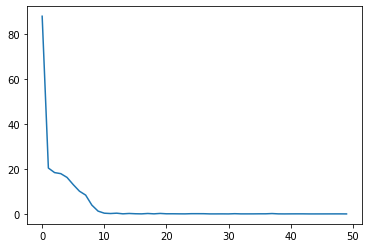

In [8]:
plt.plot(range(len(losses[:50])), losses[:50])